# **Analyzing NSW Public Transports Usage - Opal Cards' Tap-ons and Tap-offs**

## Problem Tasks: 

- Assess if **weekly personal income** data has _direct and significant impacts_ on **public transport usage**. 

The dataset includes the total number of traveling methods of each personal income group in New South Wales taken from the **_TableBuilder of the Australian Bureau of Statistics (ABS)_**. 

**The census of Australian** was conducted in 2016, and the dataset was created and filtered from the census surveys of persons in usual residence areas across New South Wales, Australia. 

📊 **Process:**
- Data preparation: 
    - Data cleaning (transpose column to row, remove logo, title of organisation, etc.). 
    - Group the income into low income (class 0 - < 1000 AUD/week) and middle-high income (class 1 - > 1000 AUD/week).
- Data exploration: Plot graphs to compare transport usage in each income group to examine whether the transport usage would correlate with low or high income group.
- Model training: Logistic Regression, KNN, Gaussian Naive Bayes and MLPClassifier models.

🎯 **Goal:**

To study whether there is a correlation between transport mode usage and income of people - whether the group of income (of an employee) can be used to predict the preferred transport modes, and whether people with higher income prefer a certain mode of transport over others.

## Import Libraries

In [5]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std

# Plot
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix

# Functions used for linear regression
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics

# Functions used for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

# Functions used for K-Nearest Neighbours Classifier
from sklearn.neighbors import KNeighborsClassifier

# Functions used for Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Functions used for Neural Network
from sklearn.neural_network import MLPClassifier

# Ignore Warning
import warnings
warnings.filterwarnings("ignore")

## Data Preparation

### Import File and Create a Dataframe

As the dataset was taken from the TableBuilder of the ABS, we have to modify the Excel file which has been read in order to convert it into an "analysable" format of dataframe.

In [6]:
# Import data, skip the rows of logo and titles/names of the organisations
df = pd.read_excel("data/transportmodevsIncome.xlsx", skiprows= 8, index_col =0, engine="openpyxl")

# Set the first row as column names
df.columns = df.iloc[0]

# Remove the first two rows after setting it as column names (second row of NaN values and an header description)
df = df.iloc[2:]

# Remove several last rows of copyright, logo and sources
df = df[:5]

# Transpose columns and rows
df = df.T

# Remove several last rows of NaN values
income_tol = df[16:17] # the index "Total"
df_income = df[:16] # not include index "Total"

# Rename columns
income_tol.columns = ["Train", "Bus", "Ferry", "Tram", "Total"]
df_income.columns = ["Train", "Bus", "Ferry", "Tram", "Total"]

# Remove first row (transport title and NaN value)
df_income = df_income.iloc[1:]

# Final dataframe
df_income

,Train,Bus,Ferry,Tram,Total
INCP Total Personal Income: weekly (annually),,,,,
Negative income,350,147,22,10,530
Nil income,1070,547,27,7,1650
"$1-$149 ($1-$7,799)",6028,5454,53,54,11586
"$150-$299 ($7,800-$15,599)",10481,5894,87,59,16526
"$300-$399 ($15,600-$20,799)",13629,6233,84,85,20030
"$400-$499 ($20,800-$25,999)",16279,7257,121,106,23755
"$500-$649 ($26,000-$33,799)",22640,9652,202,194,32679
"$650-$799 ($33,800-$41,599)",31266,11515,275,206,43265
"$800-$999 ($41,600-$51,999)",41359,13722,435,306,55825


### Group Income Range into Class

In [7]:
# Add Class column to the dataframe
idx = 5
new_col = [0,0,0,0,0,0,0,0,0,1,1,1,1,1,1]
df_income.insert(loc=idx, column="Class", value=new_col)
df_income

,Train,Bus,Ferry,Tram,Total,Class
INCP Total Personal Income: weekly (annually),,,,,,
Negative income,350,147,22,10,530,0
Nil income,1070,547,27,7,1650,0
"$1-$149 ($1-$7,799)",6028,5454,53,54,11586,0
"$150-$299 ($7,800-$15,599)",10481,5894,87,59,16526,0
"$300-$399 ($15,600-$20,799)",13629,6233,84,85,20030,0
"$400-$499 ($20,800-$25,999)",16279,7257,121,106,23755,0
"$500-$649 ($26,000-$33,799)",22640,9652,202,194,32679,0
"$650-$799 ($33,800-$41,599)",31266,11515,275,206,43265,0
"$800-$999 ($41,600-$51,999)",41359,13722,435,306,55825,0


### Data Summary

In [8]:
# DataFrame dimension
df_income.shape

(15, 6)

In [9]:
# Group by Class and sum transport mode columns
summary = df_income.groupby("Class")[["Train", "Bus", "Ferry", "Tram", "Total"]].sum()

# Display the summary
print(summary)  

        Train    Bus Ferry  Tram   Total
Class                                   
0      143102  60421  1306  1027  205846
1      231215  86021  8197  2334  327763


**Observations:**

1. **Class 1 (Higher income)** _uses public transport more_ than Class 0 (Lower income):

    - Total trips: 327,763 (Class 1) vs. 205,846 (Class 0)

    - Train is the most used mode for both classes.

2. **Higher income** = _more transport diversity_:

    - Class 1 shows higher use of bus, ferry, and tram, suggesting better access or broader commuting patterns.

3. Usage _peaks_ in **middle-to-upper income** ranges

    - Especially $800–$1,999/week groups → heavy users of all transport modes.

    - Very high incomes ($3,000+/week) show slight drop → possible shift to private transport.

## Data Exploration

Firstly, we plot a histogram of transport uses by each mode.

Text(0.5, 1.0, 'Total Usage by Transport Modes')

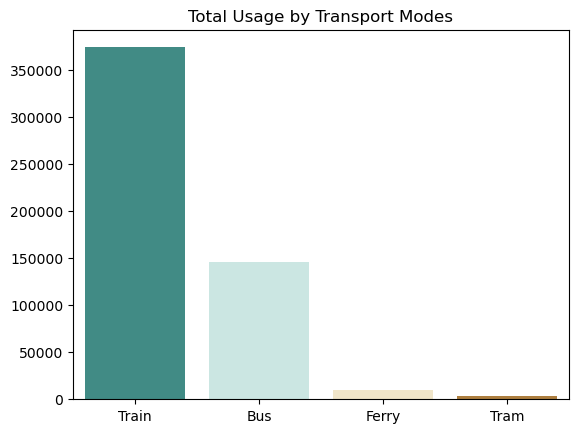

In [10]:
# Retrieve data for all transport modes and create plot
trans_modes_total = income_tol.drop(["Total"], axis=1)
sns.barplot(data= trans_modes_total, palette= "BrBG_r").set_title("Total Usage by Transport Modes")

* ***Interpretation:*** Train service has the largest number of passengers across all income groups (> 350.000 in total)

And another plot to find out how income range _uses all the transport modes_:

In [11]:
# Retrive data for all transport modes by age groups
trans_modes_by_incgr = df_income.drop(["Class", "Total"], axis=1)
trans_modes_by_incgr["Income Range"] = trans_modes_by_incgr.index
trans_modes_by_incgr

,Train,Bus,Ferry,Tram,Income Range
INCP Total Personal Income: weekly (annually),,,,,
Negative income,350,147,22,10,Negative income
Nil income,1070,547,27,7,Nil income
"$1-$149 ($1-$7,799)",6028,5454,53,54,"$1-$149 ($1-$7,799)"
"$150-$299 ($7,800-$15,599)",10481,5894,87,59,"$150-$299 ($7,800-$15,599)"
"$300-$399 ($15,600-$20,799)",13629,6233,84,85,"$300-$399 ($15,600-$20,799)"
"$400-$499 ($20,800-$25,999)",16279,7257,121,106,"$400-$499 ($20,800-$25,999)"
"$500-$649 ($26,000-$33,799)",22640,9652,202,194,"$500-$649 ($26,000-$33,799)"
"$650-$799 ($33,800-$41,599)",31266,11515,275,206,"$650-$799 ($33,800-$41,599)"
"$800-$999 ($41,600-$51,999)",41359,13722,435,306,"$800-$999 ($41,600-$51,999)"


In [12]:
# Unpivot the data by transport types
trans_modes_by_incgr_melted = pd.melt(trans_modes_by_incgr, id_vars = "Income Range", var_name="Transport Types")

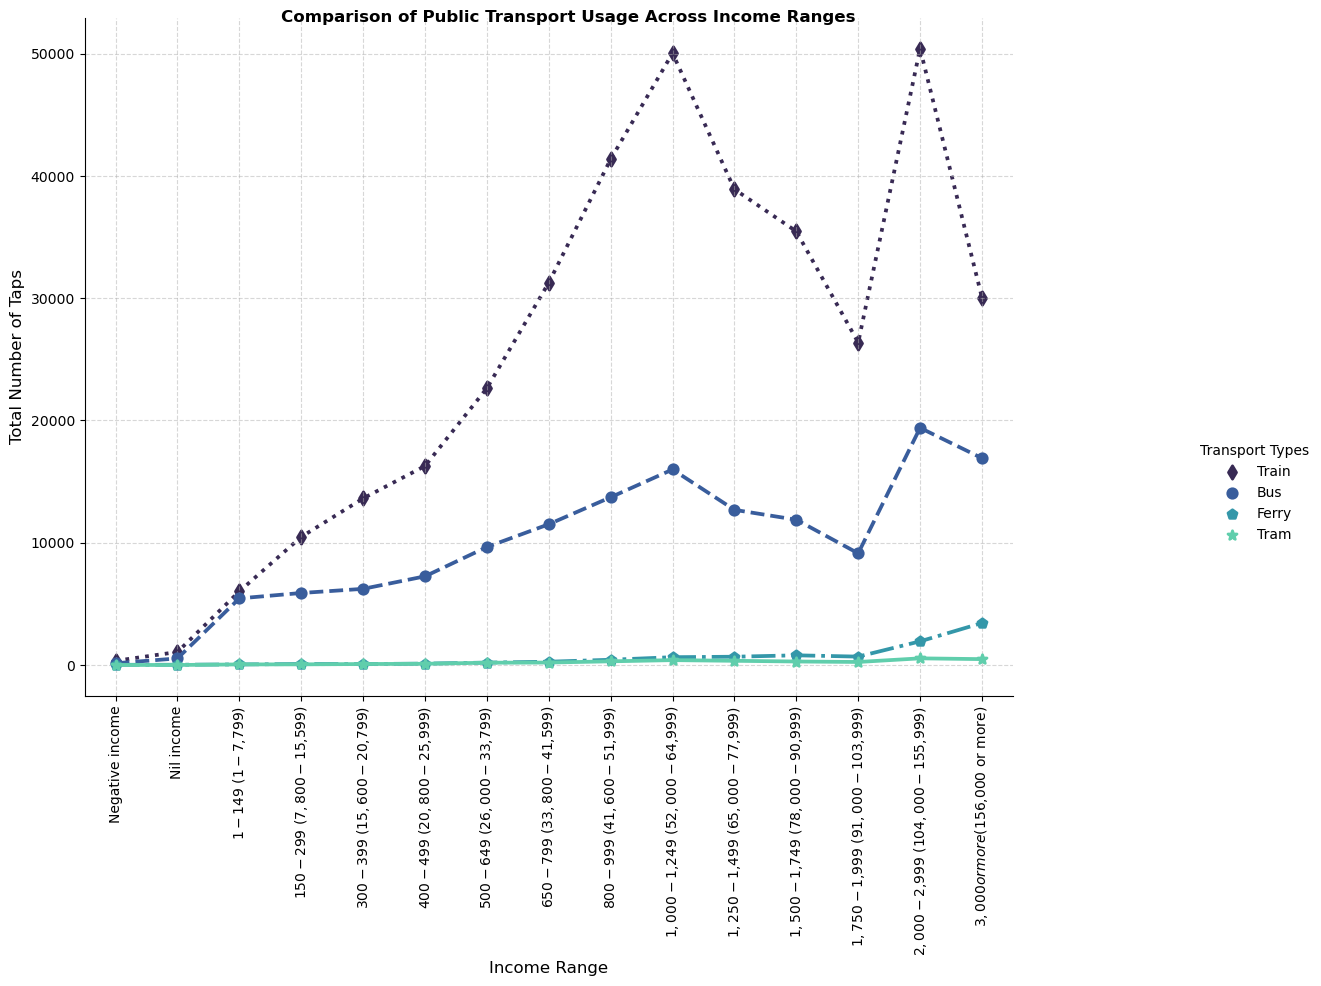

In [13]:
# Create the plot
trans_modes_by_incgr_plot = sns.catplot(
    x="Income Range", y="value",
    markers=["d", "o", "p", "*"], 
    linestyles=["dotted", "dashed", "dashdot", "solid"],
    kind="point", hue="Transport Types",
    data=trans_modes_by_incgr_melted, palette="mako"
)

# Adjust figure size
trans_modes_by_incgr_plot.fig.set_size_inches(15,8)

# Set title with better font size
trans_modes_by_incgr_plot.fig.suptitle(
    "Comparison of Public Transport Usage Across Income Ranges", 
    fontsize=12, fontweight="bold"
)

# Set axis labels
plt.xlabel("Income Range", fontsize=12)
plt.ylabel("Total Number of Taps", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add gridlines for readability
plt.grid(True, linestyle="--", alpha=0.5)

# Show the plot
plt.show()

**Key Insights:**

1. **Middle-income groups ($800–$2,999)** are the _heaviest public transport users_.

2. **Train** 🚆 is the _preferred mode_, while **bus** 🚍 serves as a _secondary option_.

3. **Ferry & tram** 🚋⛴️ are niche transport modes, _mostly used by higher-income groups_.

4. **High-income individuals ($3,000+)** 💸 may shift towards _private vehicles_.

Analyzing the usage of each transport mode by each age range in percentage will provide a proper assessment on **how all transport modes are distributed**.

In [14]:
# Transform the data to percentage
transport_modes = ["Train", "Bus", "Ferry", "Tram"]
df_income[transport_modes] = df_income[transport_modes].div(df_income["Total"], axis=0) * 100
df_income.fillna(0, inplace=True)  # Replace NaN values if any division by zero occurred
# View the updated dataframe
df_income

,Train,Bus,Ferry,Tram,Total,Class
INCP Total Personal Income: weekly (annually),,,,,,
Negative income,66.037736,27.735849,4.150943,1.886792,530,0
Nil income,64.848485,33.151515,1.636364,0.424242,1650,0
"$1-$149 ($1-$7,799)",52.02831,47.074055,0.457449,0.46608,11586,0
"$150-$299 ($7,800-$15,599)",63.421276,35.665013,0.526443,0.357013,16526,0
"$300-$399 ($15,600-$20,799)",68.042936,31.118323,0.419371,0.424363,20030,0
"$400-$499 ($20,800-$25,999)",68.528731,30.549358,0.509366,0.446222,23755,0
"$500-$649 ($26,000-$33,799)",69.279966,29.535788,0.618134,0.593653,32679,0
"$650-$799 ($33,800-$41,599)",72.266266,26.615047,0.635618,0.476135,43265,0
"$800-$999 ($41,600-$51,999)",74.086879,24.580385,0.779221,0.548142,55825,0


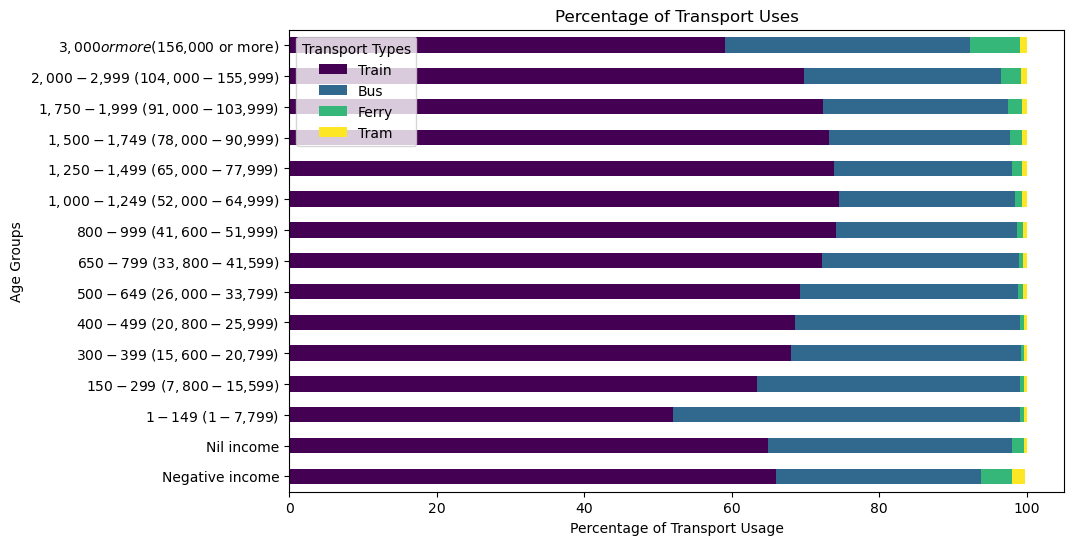

In [15]:
# Plot how all transport modes are distributed in each age range
trans_modes_by_incgr_perc = df_income[["Train", "Bus", "Ferry", "Tram"]].copy()
trans_modes_by_incgr_perc["Age Groups"] = df_income.index

trans_modes_by_incgr_perc_plot = trans_modes_by_incgr_perc.plot(
    x="Age Groups", kind="barh", stacked=True, 
    title="Percentage of Transport Uses", colormap="viridis", figsize=(10, 6)
)
trans_modes_by_incgr_perc_plot.set_xlabel("Percentage of Transport Usage")
trans_modes_by_incgr_perc_plot.set_ylabel("Age Groups")
trans_modes_by_incgr_perc_plot.legend(title="Transport Types")

**Key Insights:**
1. **Train** is still the _preferred mode across all income levels_, especially for **_middle-to-high earners_**.

2. **Bus** is _critical for_ **low-income groups** but declines as income increases.

3. **Ferry and tram** are niche transport options, mainly for higher earners.

These insights on each transport mode are all reinforced again with this plot.

## Model Training

There are two classes: 0 and 1 
* 0 is stand for the low income earner 
* 1 represented for the high income earner

### Splitting Data

In [17]:
# Split data into training and testing sets (50% each)
train, test = train_test_split(df_income, test_size=0.5, random_state=7)

# Separate features and target
X_train, X_test = train.drop(columns=['Total', 'Class']), test.drop(columns=['Total', 'Class'])
y_train, y_test = train['Class'], test['Class']

# Print shapes for verification
print(f"Train shape: {train.shape}, Test shape: {test.shape}")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Train shape: (7, 6), Test shape: (8, 6)
X_train: (7, 4), y_train: (7,)
X_test: (8, 4), y_test: (8,)


### Logistic Regression

**Fitting the model:**

In [20]:
# Create model instance and fit the training data 
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [21]:
# Produce predictions with LR model
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [23]:
# Evaluate LR model
print(f"Accuracy Score on training test: {accuracy_score(y_train, y_train_pred)}")
print(f"Accuracy Score on testing test: {accuracy_score(y_test, y_test_pred)}")

Accuracy Score on training test: 1.0
Accuracy Score on testing test: 0.625


The model has a **perfect accuracy (1.0)** on the training set but a **lower accuracy (0.625)** on the test set, which suggests **_overfitting_**.

In [ ]:
# List of accuracy scores on test set
test_scores = []
test_scores.append(accuracy_score(y_test, y_test_pred))

* <i>Comment:</i> The accuracy score is 0.75 which indicates a well-built model. However, since the dataset is small, the training accuracy score reaching 1.0 may indicate overfitting.

### Confusion matrix

In [ ]:
print ("Confusion matrix on test set:")
print(confusion_matrix(y_test,y_pred_test))

Confusion matrix on test set:
[[3 2]
 [0 3]]


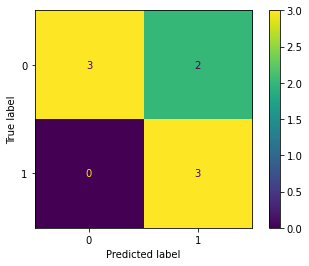

In [ ]:
plot_confusion_matrix(model, X_test, y_test)

* <i>Comment:</i> There are two false predictions of class 1 (high income) where they are actually class 0 (low income). Therefore, this model might predict incorrectly the low income group based on the number of transport uses.

In [ ]:
acc_scores = []
for i in range(1,5):
    clf = LogisticRegression(max_iter=1000)
    rfe = RFE(estimator =clf, n_features_to_select=i)
    #training model
    rfe.fit(X_train, y_train)
    #predicting on test set 
    y_pred = rfe.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    # print this
    print ("Acc on test set using", i, "feature: ", acc_score)
    print ("Feature which have been chosen:", X_train.columns[rfe.support_])
    print("")
    # append to the list 
    acc_scores.append(acc_score)

Acc on test set using 1 feature:  1.0
Feature which have been chosen: Index(['Ferry'], dtype='object')

Acc on test set using 2 feature:  1.0
Feature which have been chosen: Index(['Ferry', 'Tram'], dtype='object')

Acc on test set using 3 feature:  0.75
Feature which have been chosen: Index(['Bus', 'Ferry', 'Tram'], dtype='object')

Acc on test set using 4 feature:  0.75
Feature which have been chosen: Index(['Train', 'Bus', 'Ferry', 'Tram'], dtype='object')



### RFE

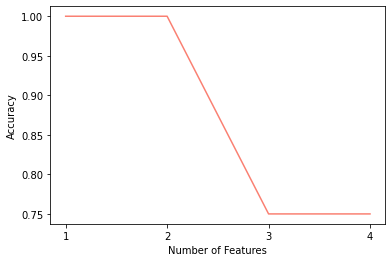

In [ ]:
# Plotting the accuracy number
plotting = plt.plot(range(1, X_train.shape[1]+1), acc_scores, color= "salmon")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.xticks(np.arange(1, 5 , step=1))
plt.show()

* <i>Comment:</i> Using 2 features in ferry and tram usage undoubtedly means precise income group prediction, while adding bus and train into the model, its accuracy score is 0.75, which is also quite good. To avoid building an overfitting model, we will choose the model with four features instead of two.

<b> Cross Validation Testing 

In [ ]:
X= df_income.drop(["Total", "Class"], axis= 1)
y= df_income["Class"]

In [ ]:
lr = LogisticRegression(max_iter=1000)
scores = cross_val_score(lr, X, y, scoring='accuracy', cv=5)
print('Accuracy range for Logistic Regression: [%.4f, %.4f]; mean: %.4f; std: %.4f\n'
      % (scores.min(), scores.max(), scores.mean(), scores.std()))
test_scores.append(scores.mean())

Accuracy range for Logistic Regression: [0.3333, 1.0000]; mean: 0.8000; std: 0.2667



### K-Nearest Neighbours Classifier

**Train and Test Sets Splitting**

In [ ]:
# choosing the nearest 3 neighbours
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
# do prediction
train_pred = clf_knn.predict(X_train)
test_pred = clf_knn.predict(X_test)

In [ ]:
print("Accuracy of the train set:", accuracy_score(y_train, train_pred))
print("Accuracy of the test set:", accuracy_score(y_test, test_pred))
test_scores.append(accuracy_score(y_test, test_pred))

Accuracy of the train set: 0.8571428571428571
Accuracy of the test set: 0.625


<b> Cross Validation Testing

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(knn, X, y, scoring='accuracy', cv=5)
print('Accuracy range for K-Nearest Neighbours: [%.4f, %.4f]; mean: %.4f; std: %.4f\n'
      % (scores.min(), scores.max(), scores.mean(), scores.std()))
test_scores.append(scores.mean())

Accuracy range for K-Nearest Neighbours: [0.6667, 1.0000]; mean: 0.7333; std: 0.1333



### Gaussian Naive Bayes

**Train and Test Sets Splitting**

In [ ]:
# train the model
clf_gnb = GaussianNB()
clf_gnb.fit(X_train, y_train)

GaussianNB()

In [ ]:
# do prediction
train_pred = clf_gnb.predict(X_train)
test_pred = clf_gnb.predict(X_test)

In [ ]:
print("Accuracy of the train set:", accuracy_score(y_train, train_pred))
print("Accuracy of the test set:", accuracy_score(y_test, test_pred))
test_scores.append(accuracy_score(y_test, test_pred))

Accuracy of the train set: 1.0
Accuracy of the test set: 0.875


<b>Cross Validation Testing

In [ ]:
gnb = GaussianNB()
scores = cross_val_score(gnb, X, y, scoring='accuracy', cv=5)
print('Accuracy range for Gaussian Naive Bayes: [%.4f, %.4f]; mean: %.4f; std: %.4f\n'
      % (scores.min(), scores.max(), scores.mean(), scores.std()))
test_scores.append(scores.mean())

Accuracy range for Gaussian Naive Bayes: [0.3333, 1.0000]; mean: 0.8667; std: 0.2667



### Multi-layer Perceptron

**Train and Test Sets Splitting**

In [ ]:
# train the model
clf_nn = MLPClassifier(max_iter=800,solver="lbfgs",activation="tanh",random_state=42)
clf_nn.fit(X_train, y_train)

MLPClassifier(activation='tanh', max_iter=800, random_state=42, solver='lbfgs')

In [ ]:
# do prediction
train_pred = clf_nn.predict(X_train)
test_pred = clf_nn.predict(X_test)

In [ ]:
print("Accuracy of the train set:", accuracy_score(y_train, train_pred))
print("Accuracy of the test set:", accuracy_score(y_test, test_pred))
test_scores.append(accuracy_score(y_test, test_pred))

Accuracy of the train set: 1.0
Accuracy of the test set: 0.75


**Cross Validation Testing**

In [ ]:
nn =  MLPClassifier(max_iter=800, solver="lbfgs",activation="tanh",random_state=42)
scores = cross_val_score(nn, X, y, scoring='accuracy', cv=5)
print('Accuracy range for Gaussian Naive Bayes: [%.4f, %.4f]; mean: %.4f; std: %.4f\n'
      % (scores.min(), scores.max(), scores.mean(), scores.std()))
test_scores.append(scores.mean())

Accuracy range for Gaussian Naive Bayes: [0.0000, 1.0000]; mean: 0.6000; std: 0.3266



### Choosing the Best Model for the Dataset

In [ ]:
# dataframe of accuracy scores
models = ["LR_Split", "LR_CV", "KNN_Split", "KNN_CV", "GNB_Split",
         "GNB_CV", "MLP_Split", "MLP_CV"]
df_acc = pd.DataFrame(models, columns=["Model Type"])
df_acc["Accuracy"] = test_scores
df_acc.head(2)

,Model Type,Accuracy
0,LR_Split,0.75
1,LR_CV,0.80


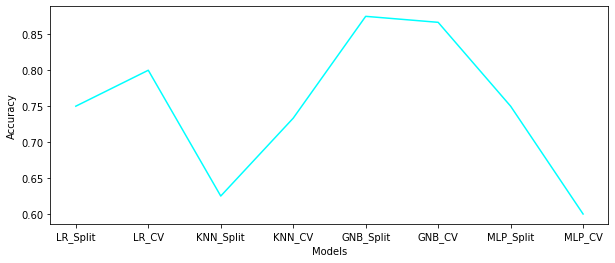

In [ ]:
# Plotting the accuracy number
plt.figure (figsize = (10,4))
plt.plot(df_acc["Model Type"], df_acc["Accuracy"], color= "aqua")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.show()

* ***Interpretation:*** We could see the Gaussian Naive Bayes model when using train test splitting is the most accurate prediction within all the models he have built so far, which the accuracy score approaching 0.87, followed by the Gaussian Naive Bayes model using the cross validation method. Therefore, the best model to predict the income group based on the uses of transport is the Gaussian Naive Bayes model.